# Predicting Detroit Blight Ticket Compliance

This notebook will construct some classifiers that will predict if a given blight ticket will be paid in Detroit. We will first begin by preprocessing the data.

In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
# Reading datasets
cols_to_keep = ['Agency Name','Inspector Name','Violator Name','Violation Date','Hearing Date','Violation Code', 
                'Disposition','Fine Amount','Late Fee','Discount Amount','Balance Due','Violation Parcel ID']
blight_violations = pd.read_csv('blight_violations.csv', usecols = cols_to_keep, low_memory = False)
blight_violations.rename(columns = {'Agency Name': 'agency_name', 'Inspector Name': 'inspector_name', 
'Violator Name': 'violator_name', 'Violation Date': 'violation_date', 'Hearing Date': 'hearing_date', 
'Violation Code': 'violation_code', 'Disposition': 'disposition', 'Fine Amount': 'fine_amount','Late Fee': 'late_fee',
'Discount Amount': 'discount_amount', 'Balance Due': 'balance_due','Violation Parcel ID': 'parcel_number'}, 
inplace = True) # Renaming columns
blight_violations.drop_duplicates(inplace = True) # Dropping duplicate rows

parcel_cols_to_keep = ['parcel_number', 'ward', 'total_square_footage', 'is_improved', 'year_built', 'sale_price', 
                       'assessed_value', 'zoning']
parcel_data = pd.read_csv('parcels.csv', usecols = parcel_cols_to_keep)
parcel_data.drop_duplicates(inplace = True)

# Merging parcel data with blight data
blight = pd.merge(blight_violations, parcel_data, on = "parcel_number")
blight.drop(columns = ['parcel_number'], inplace = True)

# Standardizing string data to make everything uppercase and removing punctuation
def standardize_text(text_col, data):
    data[text_col] = data[text_col].astype(str).apply(lambda x: x.upper())
    data[text_col] = data[text_col].apply(lambda x: re.sub(r'[^\w\s]','', x))
    return data
blight = standardize_text('agency_name', blight)
blight = standardize_text('inspector_name', blight)
blight = standardize_text('violator_name', blight)
blight = standardize_text('disposition', blight)

# Converting violation date and hearing date to a datetime data type
blight['violation_date'] = pd.to_datetime(blight['violation_date'], infer_datetime_format = True, errors = 'coerce')
blight['hearing_date'] = pd.to_datetime(blight['hearing_date'], infer_datetime_format = True, errors = 'coerce')

# Switching is_improved and ward variables to a categorical variable
blight['is_improved'] = blight['is_improved'].astype('category')
blight['ward'] = blight['ward'].astype('category')

# Creating a variable for age of the property from year_built
blight['property_age'] = blight['year_built'].max() - blight['year_built']
blight.drop(columns = ['year_built'], inplace = True)

# Creating a binary feature for compliance in paying the blight ticket
blight['compliance'] = [1 if x == 0 else 0 for x in blight['balance_due']]
blight['compliance'] = blight['compliance'].astype('category')

pd.set_option("display.max.columns", None)
blight.head()

,agency_name,inspector_name,violator_name,violation_date,hearing_date,violation_code,disposition,fine_amount,late_fee,discount_amount,balance_due,ward,total_square_footage,is_improved,sale_price,assessed_value,zoning,property_age,compliance
0,DEPARTMENT OF PUBLIC WORKS,LILLETT WILLIAMSON,KAY BEE KAY PROPERTIES LLC,2015-09-10,2015-09-30,22-2-88(b),RESPONSIBLE BY DEFAULT,200.0,0.0,0.0,230.0,18,3703.0,1,1000,14700.0,R2,100.0,0
1,BUILDINGS SAFETY ENGINEERING ENV DEPARTMENT,MONCY CHACKO,JOHN JOANN BENNETT,2017-11-15,2018-07-09,9-1-36(a),NAN,250.0,0.0,0.0,280.0,22,6229.0,1,22000,16800.0,R1,90.0,0
2,BUILDINGS SAFETY ENGINEERING ENV DEPARTMENT,MONCY CHACKO,JOHN JOANN BENNETT,2017-11-15,2018-07-09,9-1-81(a),NAN,250.0,0.0,0.0,280.0,22,6229.0,1,22000,16800.0,R1,90.0,0
3,BUILDINGS SAFETY ENGINEERING ENV DEPARTMENT,MONCY CHACKO,JOHN JOANN BENNETT,2017-11-15,2018-07-09,9-1-43(a) - (Dwelling),NAN,300.0,0.0,0.0,330.0,22,6229.0,1,22000,16800.0,R1,90.0,0
4,BUILDINGS SAFETY ENGINEERING ENV DEPARTMENT,JONATHAN STEELE,SELMA HOMES FOR GIRLS,2007-10-16,2007-11-30,9-1-81(a),RESPONSIBLE BY DEFAULT,250.0,0.0,0.0,280.0,22,6229.0,1,22000,16800.0,R1,90.0,0


In [3]:
blight.shape # size of the dataset

(334514, 19)

In [4]:
# Summarizing missing data
blight.isnull().sum()

agency_name                 0
inspector_name              0
violator_name               0
violation_date              1
hearing_date              550
violation_code              1
disposition                 0
fine_amount                 2
late_fee                    0
discount_amount             0
balance_due                 0
ward                        0
total_square_footage        0
is_improved                 0
sale_price                  0
assessed_value              0
zoning                   1822
property_age            84864
compliance                  0
dtype: int64

Since the number of missing values for the violation date, hearing date, violation code, fine amount, and zoning account for such a small percentage of the dataset, we will simply drop these observations. However, the number of missing values for the property age variable accounts for a much bigger percentage of the dataset. Due to property age being a potential significant variable in predicting blight compliance we will impute the missing values in this column with the median property age. 

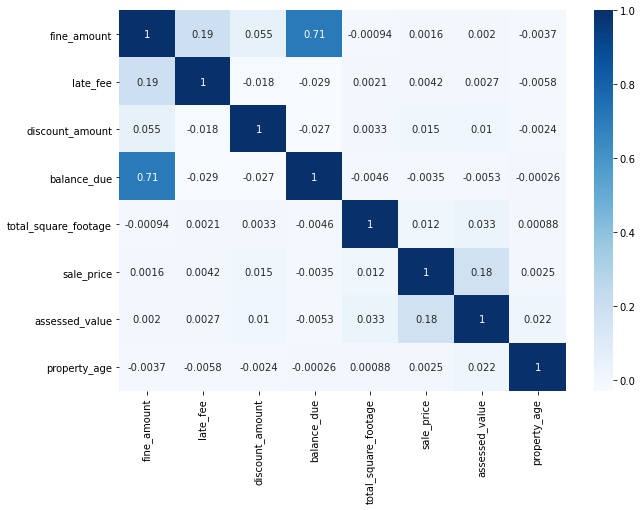

In [5]:
# Replacing property_age missing values with the median property age
blight['property_age'] = blight['property_age'].fillna(blight['property_age'].median())

# Dropping missing values from all other columns
blight.dropna(inplace = True)

# Assessing collinearity
corr_matrix = blight.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot = True, cmap = "Blues")
plt.show()

There is not many high correlations between the variables in the dataset, however, the correlation coefficient between balance due and fine amount might be of concern so we will make sure to include one or the other when modeling.

In [6]:
blight.describe()

,fine_amount,late_fee,discount_amount,balance_due,total_square_footage,sale_price,assessed_value,property_age
count,332140.000000,332140.000000,332140.000000,332140.000000,3.321400e+05,3.321400e+05,3.321400e+05,332140.000000
mean,354.413804,2.771212,0.966303,219.419188,1.100321e+04,1.281993e+05,6.013342e+04,84.920431
std,629.359811,17.270691,7.986757,532.179761,1.902099e+05,4.702863e+06,1.657065e+06,81.431226
min,1.000000,-1.000000,0.000000,-602.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,100.000000,0.000000,0.000000,0.000000,3.820000e+03,3.000000e+03,0.000000e+00,73.000000
50%,250.000000,0.000000,0.000000,80.000000,4.530000e+03,1.500000e+04,1.030000e+04,81.000000
75%,250.000000,0.000000,0.000000,280.000000,5.619000e+03,4.495000e+04,1.940000e+04,92.000000
max,10000.000000,1000.000000,1000.000000,15538.800000,2.138262e+07,7.000000e+08,4.165176e+08,2019.000000


The fee for a blight ticket ranges from \\$20 to \\$10,000. Therefore, we will remove rows which include any blight tickets that are less than \\$20 in addition to other invalid observations across other variables.

In [7]:
# Imputing NA values for sales_price, assessed_value and property_age variables
blight['sale_price'] = blight['sale_price'].mask(blight['sale_price'] == 0)
blight['sale_price'] = blight['sale_price'].fillna(blight['sale_price'].median())
blight['assessed_value'] = blight['assessed_value'].mask(blight['assessed_value'] == 0)
blight['assessed_value'] = blight['assessed_value'].fillna(blight['assessed_value'].median())
blight['property_age'] = blight['property_age'].mask(blight['property_age'] == 2019)
blight['property_age'] = blight['property_age'].fillna(blight['property_age'].median())

#Removing outliers & invalid observations
blight.drop(blight[blight['fine_amount'] < 20].index, inplace = True)
blight.drop(blight[blight['late_fee'] < 0].index, inplace = True)
blight.drop(blight[blight['balance_due'] < 0].index, inplace = True)
blight.drop(blight[blight['total_square_footage'] < 120].index, inplace = True)

Now, we will explore the Detroit blight data in more detail with exploratory data analysis (EDA).

## Exploratory Data Analysis

Text(0.5, 1.0, 'Number of Violations by Year from 2005-2017')

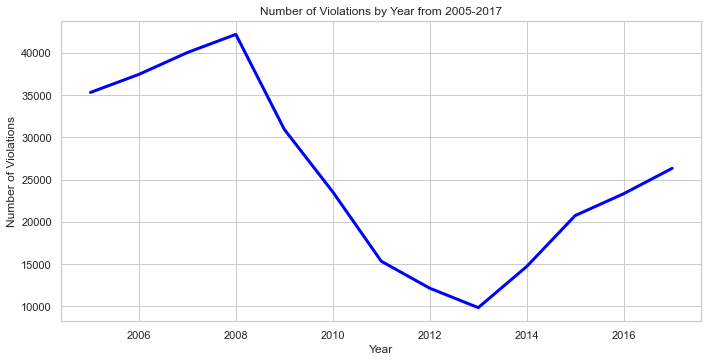

In [8]:
year = blight['violation_date'].dt.year
number_violations = blight['violation_date'].groupby([year]).agg('count')
number_violations = list(zip(number_violations.index, number_violations.values))
number_violations_df = pd.DataFrame(number_violations, columns = ['year', 'count'])
number_violations_df = number_violations_df.drop([0,1,2,3,17])
number_violations_df

plt.figure(figsize=(10, 5))
sns.set(style = "whitegrid")
sns.lineplot(x = 'year', y = 'count', data = number_violations_df, linewidth = 3, color = 'blue')
plt.tight_layout()
plt.xlabel('Year')
plt.ylabel('Number of Violations')
plt.title('Number of Violations by Year from 2005-2017')

The number of blight violations increased from 2005 and peaked at maximum of ~ 42,500 violations in 2008 likely due to the 2008 housing crisis. Then, violations declined significantly from 2008 to 2013 and has increased from 2013 to 2017.

Text(0.5, 1.0, 'Compliance Percentage by Year from 2005-2017')

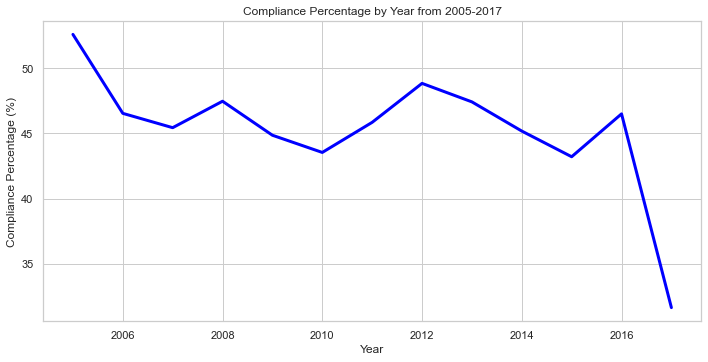

In [9]:
blight['issued_year'] = blight['violation_date'].dt.year
compliance_counts = blight['compliance'].groupby(blight['issued_year']).value_counts()
compliance_counts

year = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
compliance_perc = [52.6, 46.54, 45.44, 47.47, 44.86, 43.54, 45.85, 48.84, 47.42, 45.18, 43.21, 46.5, 31.63]
compliance_per_year = pd.DataFrame({'year': year, 'compliance_perc': compliance_perc})

plt.figure(figsize=(10, 5))
sns.set(style = "whitegrid")
sns.lineplot(x = 'year', y = 'compliance_perc', data = compliance_per_year, linewidth = 3, color = 'blue')
plt.tight_layout()
plt.xlabel('Year')
plt.ylabel('Compliance Percentage (%)')
plt.title('Compliance Percentage by Year from 2005-2017')

Since 2005, the percentage of violators who are compliant have followed a downward trend.

In [10]:
# Looking at the distribution of compliance
blight["compliance"].value_counts(normalize = True)

0    0.545966
1    0.454034
Name: compliance, dtype: float64

The percentage of tickets that are not paid on time is 54.6% and the percentage of tickets that are paid on time is 45.4%.

In [11]:
blight['fine_amount'].describe()

count    332017.000000
mean        354.443167
std         629.432413
min          20.000000
25%         100.000000
50%         250.000000
75%         250.000000
max       10000.000000
Name: fine_amount, dtype: float64

The average blight ticket fine is $354.44.

In [12]:
# Summarizing fine amounts by agency
blight.groupby('agency_name')['fine_amount'].mean()

agency_name
BUILDINGS SAFETY ENGINEERING  ENV DEPARTMENT    287.269013
DEPARTMENT OF PUBLIC WORKS                      456.890771
DETROIT POLICE DEPARTMENT                       254.382936
HEALTH DEPARTMENT                               336.493207
Name: fine_amount, dtype: float64

Compared to the average blight ticket fine, the Department of Public Works fines the highest blight ticket average of \\$456.89 while the Detroit Police Department, surprisingly, fines the lowest ticket average at \\$287.27. The Department of Public Works in Detroit is primarily responsible for the environmental and infrastructure sector of the city and oversees the cleanliness of the city. This might suggest that a majority of the blight ticket fines come from residents failing to manage waste and trash, removing snow and ice, or keeping grass from growing too high on their residences. Now, we will explore some of the relationships between the numerical variables and blight compliance.

### Exploring Compliance by Fees

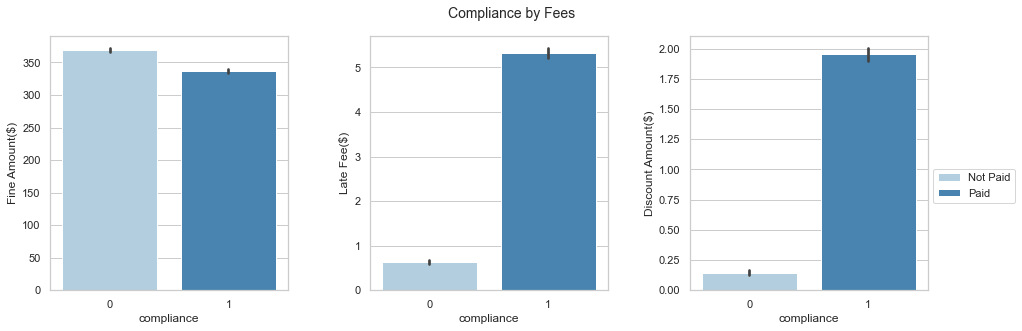

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('Compliance by Fees', fontsize = 14)

labels = ["Not Paid", "Paid"]
# Creating new dataframe column with labels instead of number
blight['ticket_compliance'] = blight['compliance'].map(dict(zip(range(0,2), labels)))

fine_barplot = sns.barplot(x = 'compliance', y = 'fine_amount', data = blight, dodge = False, ax = ax1, 
                           palette = 'Blues' )
fine_barplot.set_ylabel("Fine Amount($)")
latefee_barplot = sns.barplot(x = 'compliance', y = 'late_fee', data = blight, dodge = False, ax = ax2,
                             palette = 'Blues')
latefee_barplot.set_ylabel("Late Fee($)")
discount_barplot = sns.barplot(x = 'compliance', y = 'discount_amount', hue = "ticket_compliance", data = blight, 
                               dodge = False, ax = ax3, palette = 'Blues')
discount_barplot.set_ylabel("Discount Amount($)")
plt.legend(bbox_to_anchor = (1, 0.5))
fig.tight_layout(pad = 3.0)
plt.show()

In looking at compliance by fine amount, it appears that there is not much difference in the average fine amount between tickets that are paid on time and tickets that are not paid. The tickets that are not paid on time have a slightly higher average fine amount than those paid on time. On the other hand, the relationship between compliance and late fee and the relationship betwen compliance and discount amount are significant as there is a noticeable difference between the two groups of compliance. It is counterintuitive that the average late fee is higher for tickets paid than tickets not paid. The average discount amount is mostly higher for tickets paid on time likely due to the fact that a discount would coerce more blight violators to pay.

### Analyzing Compliance by Property Features

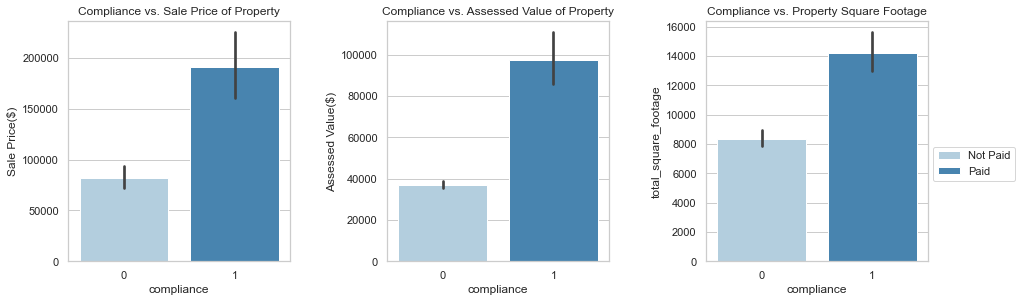

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))

sp_barplot = sns.barplot(x = 'compliance', y = 'sale_price', data = blight, dodge = False, ax = ax1,
                                palette = 'Blues')
sp_barplot.set_ylabel("Sale Price($)")
sp_barplot.axes.set_title("Compliance vs. Sale Price of Property")

av_barplot = sns.barplot(x = 'compliance', y = 'assessed_value', data = blight, dodge = False, ax = ax2,
                                palette = 'Blues')
av_barplot.set_ylabel("Assessed Value($)")
av_barplot.axes.set_title("Compliance vs. Assessed Value of Property")

sqft_barplot = sns.barplot(x = 'compliance', y = 'total_square_footage', hue = "ticket_compliance", data = blight, 
                           dodge = False, ax = ax3, palette = 'Blues')
sqft_barplot.axes.set_title("Compliance vs. Property Square Footage")
plt.legend(bbox_to_anchor = (1, 0.5))
fig.tight_layout(pad = 3.0)

In regards to property value, it is apparent that the average sales price of properties that are compliant is close to \\$200,000 and the average assessed value of properties that are compliant is close to \\$100,000 and there is a very distinct difference in sales price between those who are and are not compliant. We can infer that owners of properties with a higher sales price and assessed value most likely have higher incomes, and thus are more likely to pay their blight fees. Compliance by square footage also mirrors the relationship between sales price and assessed value and their effect on compliance.

### Analyzing Compliance by Property Condition

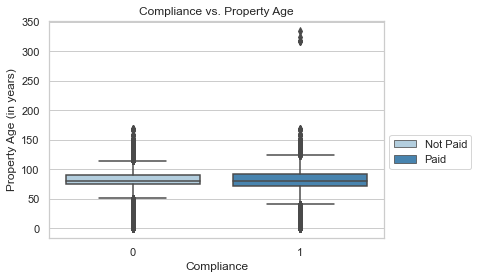

In [15]:
age_bplot = sns.boxplot(x = blight['compliance'], y = blight['property_age'], palette = 'Blues', 
                       hue = 'ticket_compliance', data = blight, dodge = False)
age_bplot.axes.set_title("Compliance vs. Property Age")
age_bplot.set_xlabel("Compliance")
age_bplot.set_ylabel("Property Age (in years)")
plt.legend(bbox_to_anchor = (1, 0.5))
plt.show()

There appears to be some outliers in the compliant group with properties whose age is greater than 300 years. However, this does not seem realistic, so we will drop these outliers.

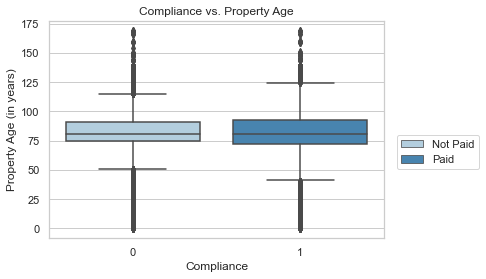

In [16]:
blight.drop(blight[blight['property_age'] > 300].index, inplace = True)

age_bplot = sns.boxplot(x = blight['compliance'], y = blight['property_age'], palette = 'Blues', 
                       hue = 'ticket_compliance', data = blight, dodge = False)
age_bplot.axes.set_title("Compliance vs. Property Age")
age_bplot.set_xlabel("Compliance")
age_bplot.set_ylabel("Property Age (in years)")
plt.legend(bbox_to_anchor = (1.3, .5))
plt.show()

The age of a property and whether or not a blight violator pays a ticket on time does not appear to have a significant relationship as there is no difference in the distribution of those who are and are not compliant. The median property age is basically the same for both groups, however, there is slightly more variability in property age for those who are compliant.

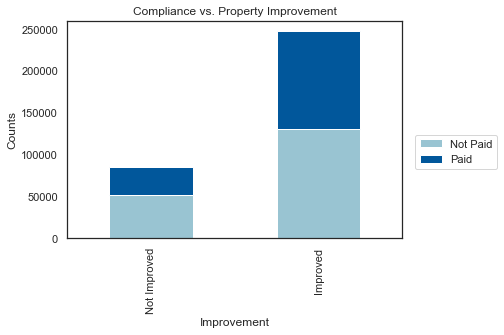

In [17]:
blight.groupby('is_improved')['compliance'].value_counts()

plotdata = pd.DataFrame({
    'Not Paid': [50968, 130302],
    'Paid': [33392, 117349]
    }, index = ['Not Improved', 'Improved'])
sns.set_style("white")
plotdata.plot(kind ='bar', stacked = True, color = ['#99c4d2', '#01579b'])
plt.title("Compliance vs. Property Improvement")
plt.xlabel("Improvement")
plt.ylabel("Counts")
plt.legend(bbox_to_anchor = (1.3, .5))

For properties that have not been improved, there is a greater proportion of blight violators that are not compliant in paying their blight ticket versus those who are compliant and the same follows for properties that have been improved. However, properties that have been improved have a higher proportion of compliance compared to properties that were not improved. Now, we will explore compliance by other categorical variables.

In [18]:
other_categorical_vars = ['agency_name', 'inspector_name', 'violator_name', 'violation_code', 'disposition', 'ward',
                         'zoning']
[blight[feature].value_counts().size for feature in other_categorical_vars]

[4, 263, 138912, 254, 14, 22, 28]

It seems that all of these categorical variables have a high number of levels except for agency name which may make models too complex later on and possibly overfit. Therefore, we will discard all of these columns except agency name. 

In [19]:
columns_to_drop = ['inspector_name', 'violator_name', 'violation_code', 'disposition', 'ward', 'zoning']
blight.drop(columns = columns_to_drop, inplace = True)

### Compliance by Agency

Text(0, 0.5, 'Agency')

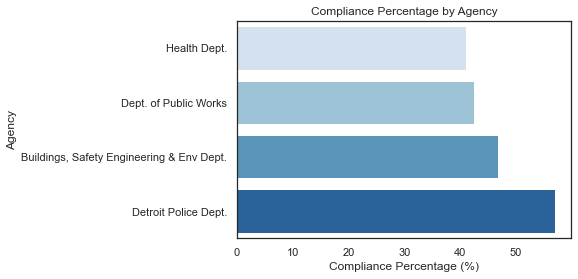

In [20]:
blight.groupby('agency_name')['compliance'].value_counts()
agency = ['Buildings, Safety Engineering & Env Dept.', 'Dept. of Public Works', 'Detroit Police Dept.', 
          'Health Dept.']
compliance_perc = [46.84, 42.54, 57.04, 41.12]
data = {'agency': agency, 'compliance_perc': compliance_perc}
compliance_by_agency = pd.DataFrame(data)

sns.barplot(x = 'compliance_perc', y = 'agency', data = compliance_by_agency, palette = "Blues", 
            order = ['Health Dept.', 'Dept. of Public Works', 'Buildings, Safety Engineering & Env Dept.',
                    'Detroit Police Dept.'] )
plt.title("Compliance Percentage by Agency")
plt.xlabel("Compliance Percentage (%)")
plt.ylabel("Agency")

In terms of compliance by agency, the Detroit Police Department has the highest percentage of ticket compliance (over 50%) while the Health Department has the lowest percentage of ticket compliance. It appears that inspectors within the Detroit Police Department are better in expediting compliance compared to the other agencies. It might be of benefit if other departments got in touch with the Detroit Police Department to look at their strategies in getting more violators to comply.

## Modeling

We will start the modeling process by first randomly splitting the data into a training and testing set keeping only data from 2005 to 2018. We will do a 60-40 split with 60% of the data being included in the training set and 40% of the data in the test set.

### Logistic Regression Classifier

In [21]:
blight.drop(blight[blight['issued_year'] < 2005].index, inplace = True) # dropping data with issued years < 2005

# One-hot encoding categorical variables agency_name
blight = pd.get_dummies(blight, columns = ['agency_name', 'is_improved'], drop_first = True)
blight.rename(columns = {'agency_name_DEPARTMENT OF PUBLIC WORKS': 'agency_name_Dept of Public Works', 
'agency_name_DETROIT POLICE DEPARTMENT':'agency_name_Detroit Police Dept', 'is_improved_1': 'improved'}, 
inplace = True)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

predictors = ['fine_amount', 'late_fee', 'discount_amount', 'sale_price', 'assessed_value', 
              'total_square_footage', 'improved', 'agency_name_Dept of Public Works', 
              'agency_name_Detroit Police Dept']

X = blight[predictors]
y = blight['compliance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.648881
         Iterations 7
                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:      0.058      
Dependent Variable:      compliance            AIC:                   258521.8470
Date:                    2020-08-18 19:30      BIC:                   258613.6652
No. Observations:        199192                Log-Likelihood:        -1.2925e+05
Df Model:                8                     LL-Null:               -1.3717e+05
Df Residuals:            199183                LLR p-value:           0.0000     
Converged:               1.0000                Scale:                 1.0000     
No. Iterations:          7.0000                                                  
---------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------

All of the variables in this model are significant.

In [23]:
# Fitting logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_score = logreg.predict(X_train)
print('AUC score for training set:', round(roc_auc_score(y_train, y_score), 4))

AUC score for training set: 0.5134


In [24]:
# Testing Performance
y_score = logreg.predict(X_test)
print('AUC score for test set:', round(roc_auc_score(y_test, y_score), 4))

AUC score for test set: 0.5125


The accuracy in predicting compliance using a logistic regression classifier is not that good on the unseen data. Let's see if we can do better with some ensemble methods.

### Random Forest Classifier

Before we train our random forest classifier, we will use a randomized search to determine the best parameters for the number of trees and the maximum depth of those trees for this classifier.

In [25]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import RandomizedSearchCV

#n_estimators = [int(x) for x in np.linspace(100, 600, 100)]
#max_depth = [int(x) for x in np.linspace(2, 20, 2)]

# Creating the parameter grid 
#random_grid = {
#   'n_estimators': n_estimators,
#   'max_depth': max_depth
#}

# Create a based model
#rf = RandomForestClassifier()
#rf_random_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 5, verbose = 1, 
#                                      n_jobs = -1, random_state = 1, n_iter = 100)
#rf_random_search.fit(X_train, y_train)
#rf_random_search.best_params_

From the randomized search, the best parameters to use for our random forest classifier is 589 trees and 20 for the maximum number of levels in each tree. We will use 3 for the maximum number of features for each split which is the square root of the number of variables used in modeling.

In [26]:
# Fitting random forest classifier
rf = RandomForestClassifier(n_estimators = 589, max_features = 3, max_depth = 20, random_state = 1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)

# Training results
print('AUC score for training set:', round(roc_auc_score(y_train, y_pred), 4))

# Test results
y_test_pred = rf.predict(X_test)
print('AUC score for test set:', round(roc_auc_score(y_test, y_test_pred), 4))

AUC score for training set: 0.7254
AUC score for test set: 0.6525


Text(0.5, 1.0, 'Variable Importances')

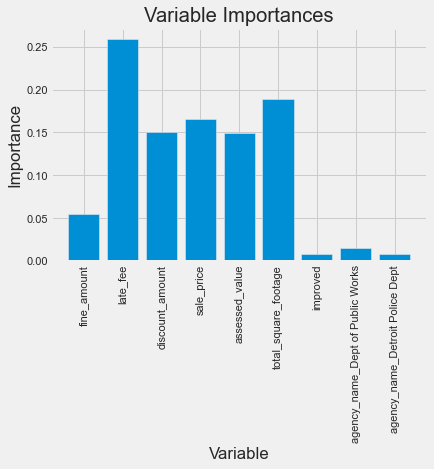

In [27]:
# Get numerical feature importances
feature_list = list(X.columns)
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Plot of variable importance
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')

From our random forest classifier, we see that the late fee, square footage of the property, assessed value of the property, the discount amount and the sale price are the top features in predicting whether a violator will pay a fine or not.

### Gradient Boosting Classifier 

We will first start by implementing a randomized search to select the best parameters for the number of trees and the learning rate for our gradient boosting classifier and then use a grid search for the maximum depth of the trees before fitting.

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

#n_estimators = [int(x) for x in np.linspace(100, 600, 100)]
#learning_rate = [0.001, 0.01, 0.05, 0.1, 0.25]

# Creating the parameter grid 
#random_grid = {
#   'n_estimators': n_estimators,
#   'learning_rate': learning_rate
#}

# Create a based model
#gb = GradientBoostingClassifier()

# Implementing grid search to select best parameters for the classifier
#gb_random_search = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, cv = 5, verbose = 1, 
#                                      n_jobs = -1, random_state = 1, n_iter = 100)
#gb_random_search.fit(X_train, y_train)
#gb_random_search.best_params_

In [29]:
#from sklearn.model_selection import GridSearchCV

#max_depth = [2, 3, 4, 5, 6, 7, 8]

#param_grid = {
#    'max_depth': max_depth
#}

#gb = GradientBoostingClassifier()

#gb_gridsearch = GridSearchCV(estimator = gb, param_grid = param_grid, cv = 5, verbose = 1, n_jobs = -1)
#gb_gridsearch.fit(X_train, y_train)
#gb_gridsearch.best_params_

The parameters that are chosen are 564 trees, a learning rate of 0.25, and a maximum depth of 8 for the trees.

In [30]:
# Fitting gradient boosting classifier
model = GradientBoostingClassifier(learning_rate = 0.25, max_depth = 8, n_estimators = 564)
model.fit(X_train, y_train)
model_pred = model.predict(X_train)

# Training results
print('AUC score for training set:', round(roc_auc_score(y_train, model_pred), 4))

# Test results
model_test_pred = model.predict(X_test)
print('AUC score for test set:', round(roc_auc_score(y_test, model_test_pred), 4))

AUC score for training set: 0.7947
AUC score for test set: 0.6763


Text(0.5, 1.0, 'Variable Importances')

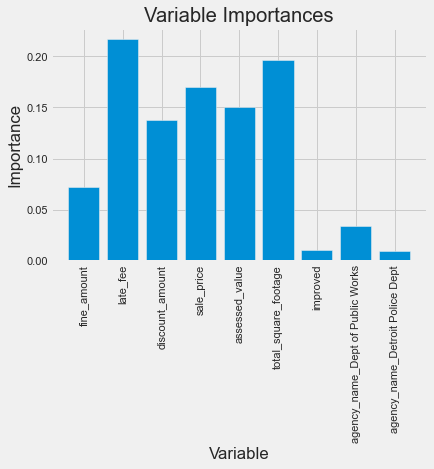

In [31]:
# Get numerical feature importances
feature_list = list(X.columns)
importances = list(model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Plot of variable importance
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')

We see that the same 5 variables: late fee, discount amount, sale price, assessed value and square footage of the property are most important in classifying whether a blight ticket will be paid or not according to our gradient boosting classifier.

## Results

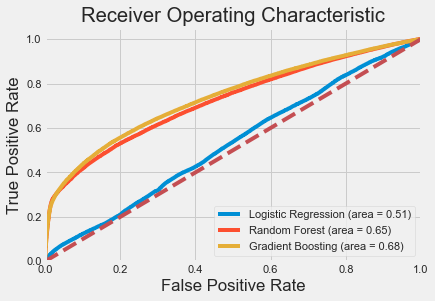

In [32]:
from sklearn.metrics import roc_curve

# Calculate values for ROC AUC plot

# Logistic Regression Model
logistic_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr1, tpr1, thresholds1 = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
# Random Forest Model
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr2, tpr2, thresholds2 = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
# Gradient Boosting Model 
gb_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr3, tpr3, thresholds3 = roc_curve(y_test, model.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr1, tpr1, label = 'Logistic Regression (area = %0.2f)' % logistic_roc_auc)
plt.plot(fpr2, tpr2, label = 'Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(fpr3, tpr3, label = 'Gradient Boosting (area = %0.2f)' % gb_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.show()

The gradient boosting classifier achieved the highest area under the ROC curve, therefore, it performed the best in predicting whether a violator will pay their blight fine. The random forest classifier is not far from the gradient boosting classifier in terms of performance. If time permitted itself, we could further tune some parameters of the gradient boosting classifier including the minimum number of samples for each split and for each leaf and use only the most important variables determined by our random forest classifier in the model. When targeting compliance, the City of Detroit should pay most attention to violators with late fees and violators who have many blight tickets. 